# Title

## Introduction

Minecraft is a sandbox video game where players explore and build in a world made of blocks. In this world of infinite possibilities, we would like to analyze the relationship between player behaviors and their demographics. This data was collected by a Computer Science research group at UBC led by Frank Wood. The method in which they collected data was recording players' actions throughout the world in their Minecraft servers. They provide two data sets, one of player data that contains a list of unique players and their data, and another that contains a list of individual game sessions made by each player. Specifically, we would like to know what Minecraft player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how each player differs from each other.
### Question:
Can the variables played_hours, number of sessions played ~gender, experience,~ and age predict whether or not a Minecraft player will subscribe to a game-related newsletter?

As we are only looking at player demographic and behavioural data, we will only use the first data set, players.csv that contains the list of players and their respective game data. This data set contains 196 total observations and 7 variables: subscribe, gender, age, name, played_hours, hashedEmail and experience. Out of all the variables, the predictors of subscribing are experience, played_hours, gender and age. The columns email and name will be left out as these varibles do not contribute to newsletter subscription.

***(version for using both datasets if everyone is okay with it) ***
We will be using both datasets to explore this question. The players.csv data contains the list of players, 196, and seven variables for each player. The variables are subscribe, gender, age, name, played_hours, hashedEmail, and experience. To predict wether a player has subscribed we will use the quantitative variables of age and played_hours. We will also use sessions.csv which records each session played for a total of 1535 observations. The sessions data includes the same hashedEmail identifier as players.csv, start time and end time, as well as original start and end time. The only information we will take from sessions.csv is the number of occurrences of each hashedEmail which can also be interpretted as the number of sessions a player has played.

- The subscribe variable is categorical and contains 2 possible values: "TRUE" or "FALSE". This shows whether a player has subscribed to a game related newsletter or not.

~- The experience variable is categorical and contains 5 possible values: "Beginner", "Amateur", "Regular", "Pro" and "Veteran". These placeholders describe the level of skill and experience each player has rated themselves from least to most experienced.~

- The played_hours variable is numeric and up to 1 decimal place. This variable, quantified in hours, was determined through how long each player played Minecraft in one sitting.

~- The gender variable is categorical and contains 7 options: "Male", "Female", "Non-binary", "Prefer not to say", "Agender", "Two-spirited" and "Other." This variable shows the gender of the player.~

- The age variable is numeric and contains integer values. This variable is the age of the player.

A noticeable issue is that this data contains some outliers in the played_hours variable. Some players have claimed to play over 200 hours of Minecraft in a single session. These points may affect the classification model in predictions. 



## Methods & Results

First we need to load in both dataset and wrangle them seperately. For the session.csv data we will group the 1535 observations by the hashedEmail variable to find the number of sessions each individual has played. For players.csv we will change the variable name 'Age' to 'age' to follow a consistent naming pattern, change the subscribe variable to a factor datatype, and deselect the variables we do not need such as name, experience, and gender. From here we can merge the two datasets and deselect the hashedEmail as it will no longer be needed. 

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(scales)
library(cowplot)
library(themis)
options(repr.matrix.max.rows = 6) # i got these loading steps from other assignments we've done. im not really sure
#source('cleanup.R') # if they are all necesary tho so feel free to remove

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
# loading in datasets
players = read_csv("data/players.csv")
players
sessions = read_csv("data/sessions.csv")

# combining the observations so that each hashedEmail has the number of sessions played beside it
indiv_sessions <- sessions |> 
group_by(hashedEmail) |>
summarize(sessions_played = n()) 

#data wrangeling for players
predictor_data <- players |>
    mutate(age = Age,
          subscribe = as.factor(subscribe)) |>
    select(-experience, -name, -gender, -Age) |>
    drop_na()

complete_data <- merge(x = predictor_data, y = indiv_sessions, by = "hashedEmail")
minecraft_data <- select(complete_data, -hashedEmail)
minecraft_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


subscribe,played_hours,age,sessions_played
<fct>,<dbl>,<dbl>,<int>
TRUE,1.5,20,2
FALSE,0.4,21,1
TRUE,0.1,17,1
⋮,⋮,⋮,⋮
TRUE,56.1,23,310
TRUE,0.1,17,1
TRUE,1.1,20,1


The players data was filtered for the response variable and numerical predictors for classification: subscribe, played_hours and age. The session data was grouped by hashed email for data on each player, and then the number of sessions was summarized. These two data sets were then merged into one clean wrangled data set: "minecraft_data".

Summary:

In [3]:
subscribed_true <- minecraft_data |>
filter(subscribe == TRUE) |>
nrow()
subscribed_false <- minecraft_data |>
filter(subscribe == FALSE) |>
nrow()
subscribed_true
subscribed_false

[1] 91

[1] 32

The following is a scatterplot of minecraft_data. This provides a rough idea for the variables that correspond to either subscribing or not subscribing to the newsletter.

Warning message in scale_x_log10(labels = label_comma()):
“log-10 transformation introduced infinite values.”


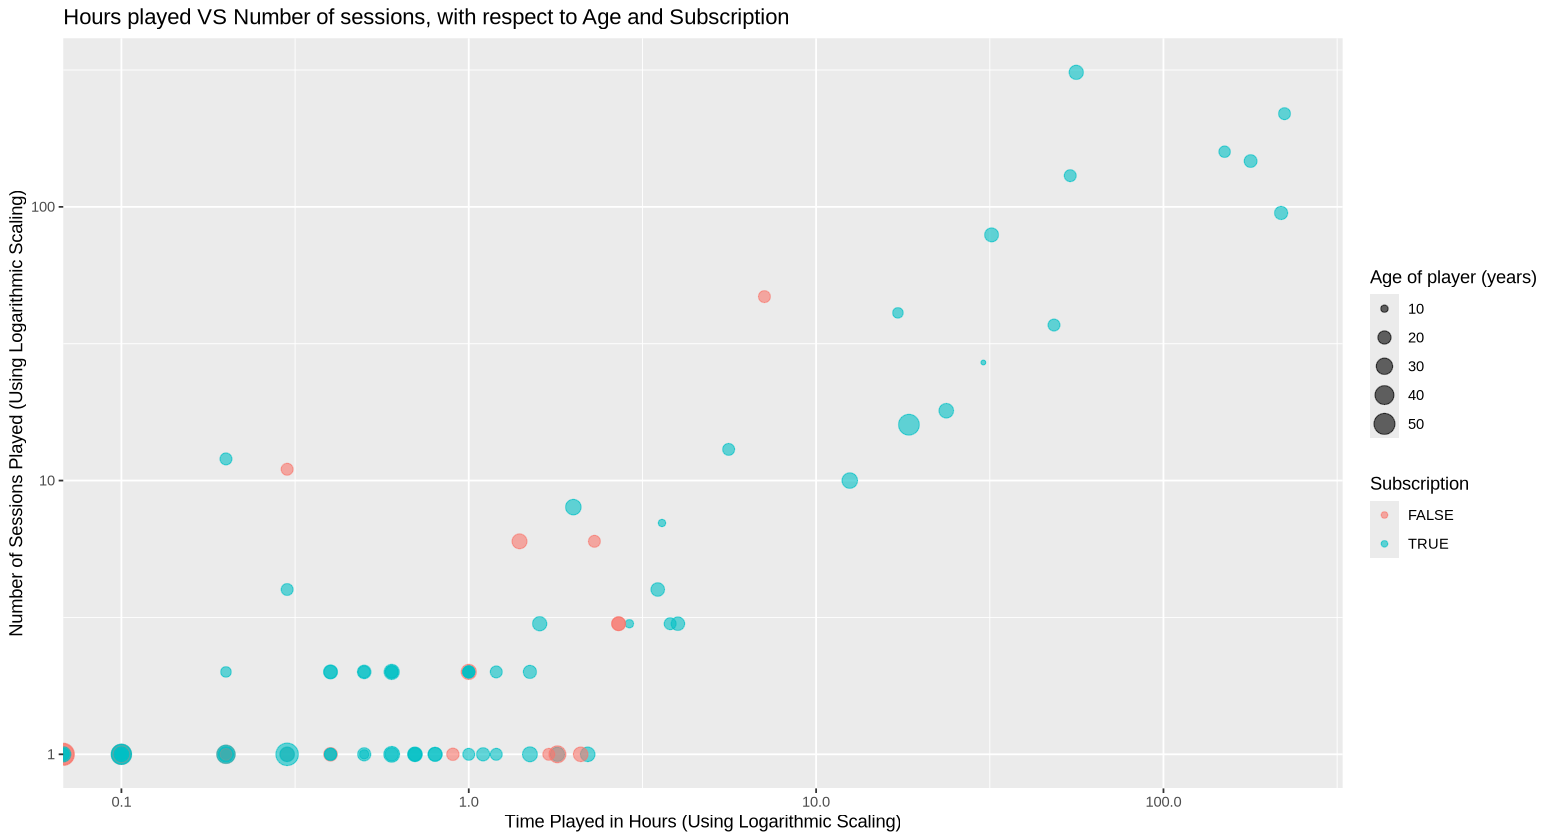

In [26]:
options(repr.plot.width = 13)
clean_data_plot <- minecraft_data |>
    ggplot(aes(x = played_hours, y = sessions_played, size = age, colour = subscribe)) +
    geom_point(alpha = 0.6) +
    labs(x = "Time Played in Hours (Using Logarithmic Scaling)", 
         y = "Number of Sessions Played (Using Logarithmic Scaling)", 
         size = "Age of player (years)", 
         colour = "Subscription") +
    ggtitle("Hours played VS Number of sessions, with respect to Age and Subscription") +
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma()) 
clean_data_plot

Do we add an anaylsis here or does that come in results??


Now we can start our analysis by tuning and training our model. We will spilt the data into 75% training and 25% testing and specify that we are using subscribe as our strata variable. Now using minecraft_training we can create a recipe that standarzizes the data and oversamples the 'FALSE' observation as we noted earlier it is less common than the 'TRUE' observation. To find the most accurate K value, we set neighbors to the tune() function and did five fold cross validation testing for values ranging from 1-20.

In [6]:
set.seed(1243)

minecraft_split <- initial_split(minecraft_data, prop = 0.75, strata = subscribe)  
minecraft_train <- training(minecraft_split)   
minecraft_test <- testing(minecraft_split)

minecraft_recipe_upsample <- recipe(subscribe ~., data = minecraft_train) |>
    step_scale(all_predictors())|>
    step_center(all_predictors()) |>
    step_upsample(subscribe, over_ratio = 1, skip = TRUE) 

knn_tune <- nearest_neighbor(weight_func = 'rectangular' , neighbors = tune()) |>
      set_engine('kknn') |>
      set_mode('classification') 

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

minecraft_vfold <- vfold_cv(minecraft_train, v = 5, strata = subscribe)

knn_results <- workflow() |>
      add_recipe(minecraft_recipe_upsample) |>
      add_model(knn_tune) |>
      tune_grid(resamples = minecraft_vfold, grid = k_vals) |>
      collect_metrics()
knn_results


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6305814,5,0.04440425,Preprocessor1_Model01
1,roc_auc,binary,0.5717033,5,0.04493753,Preprocessor1_Model01
2,accuracy,binary,0.6305814,5,0.04440425,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
19,roc_auc,binary,0.5413187,5,0.12630474,Preprocessor1_Model19
20,accuracy,binary,0.5537668,5,0.06644104,Preprocessor1_Model20
20,roc_auc,binary,0.5223626,5,0.10389504,Preprocessor1_Model20


We can visualize the accuracy of each K on the plot below and use the slice_max function to find that the best value for K is 11.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6305814,5,0.04440425,Preprocessor1_Model01
2,accuracy,binary,0.6305814,5,0.04440425,Preprocessor1_Model02


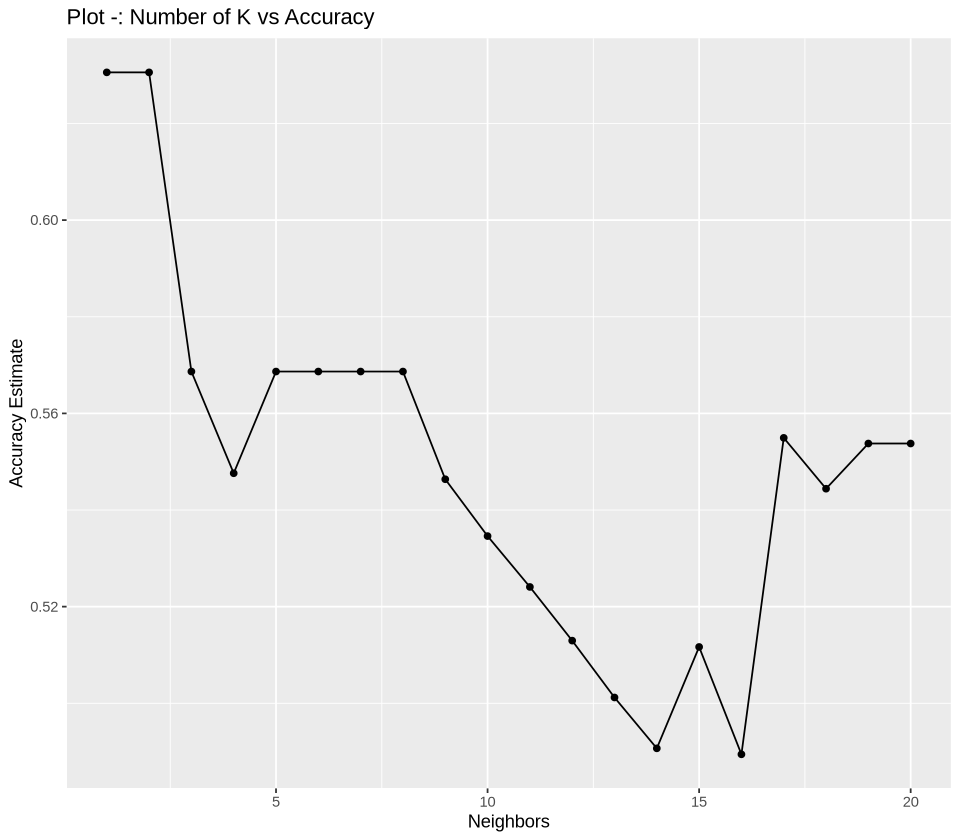

In [30]:
options(repr.plot.width = 8)
accuracies <- knn_results |> 
      filter(.metric == 'accuracy') 

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      ggtitle('Plot -: Number of K vs Accuracy')
accuracy_versus_k 

best_k <- slice_max(accuracies, order_by= mean, n=1)
best_k

Knowing that our ideal value of K is 2 we can retrain the model using the same recipe.

In [31]:
minecraft_recipe <- recipe(subscribe ~., data = minecraft_train) |>
    step_scale(all_predictors())|>
    step_center(all_predictors()) 

knn <- nearest_neighbor(weight_func = 'rectangular' , neighbors = 2) |>
      set_engine('kknn') |>
      set_mode('classification')

knn_fit <- workflow() |>
      add_recipe(minecraft_recipe_upsample) |>
      add_model(knn) |>
      fit(data = minecraft_train)

Now having the fully trained model we can predict the values of the testing set and attempt to evaluate accuracy.

In [20]:
test_predictions <- predict(knn_fit, minecraft_test) |>
bind_cols(minecraft_test) 

data_for_plot <- test_predictions |>
mutate(predicted_correct = .pred_class == subscribe)
data_for_plot

metrics <- test_predictions |>
    metrics(truth = subscribe, estimate = .pred_class)  |>
    filter(.metric == "accuracy")
metrics

matrix <- test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
matrix

.pred_class,subscribe,played_hours,age,sessions_played,predicted_correct
<fct>,<fct>,<dbl>,<dbl>,<int>,<lgl>
TRUE,TRUE,0.7,21,1,TRUE
TRUE,TRUE,0.6,19,2,TRUE
TRUE,TRUE,1.2,17,2,TRUE
⋮,⋮,⋮,⋮,⋮,⋮
FALSE,TRUE,3.8,17,3,FALSE
TRUE,TRUE,3.5,21,4,TRUE
TRUE,TRUE,1.1,20,1,TRUE


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6129032


          Truth
Prediction FALSE TRUE
     FALSE     2    6
     TRUE      6   17

Warning message in scale_x_log10(labels = label_comma()):
“log-10 transformation introduced infinite values.”
Warning message in geom_histogram(bindwidth = 5):
“Ignoring unknown parameters: `bindwidth`”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


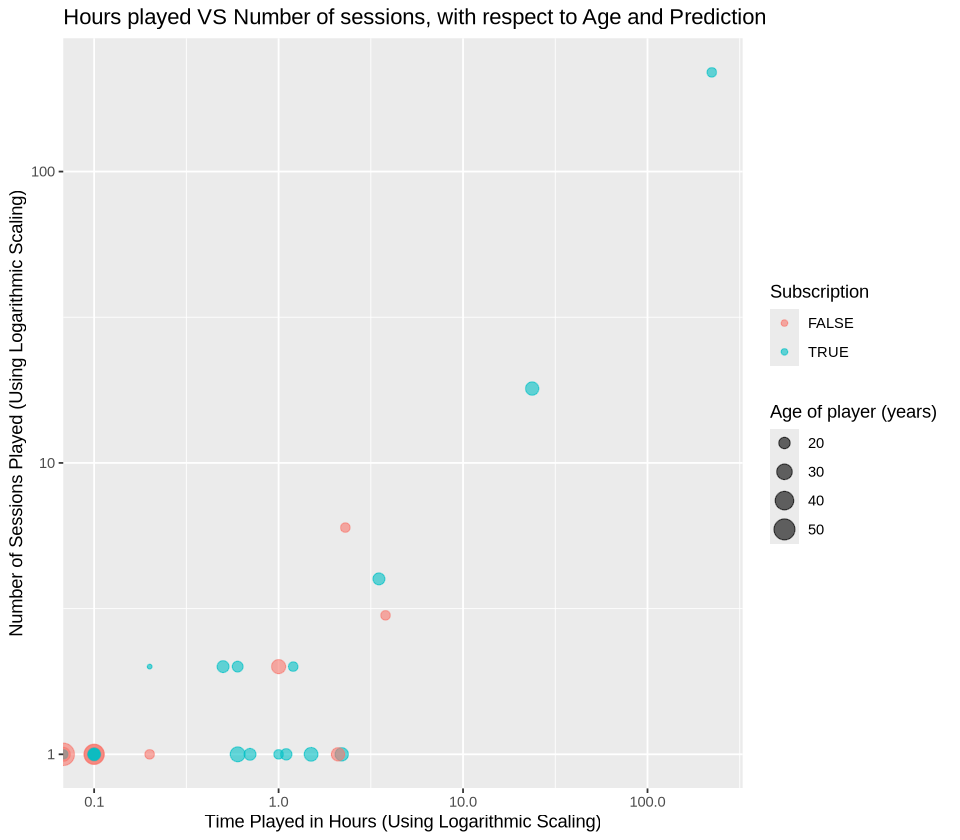

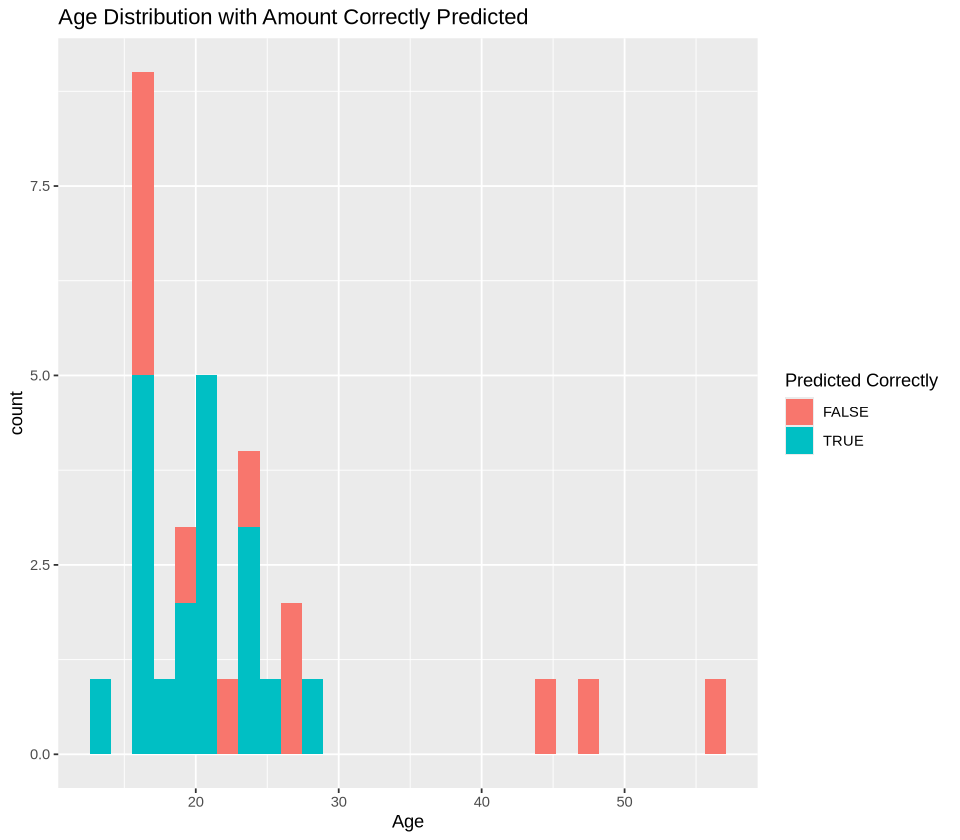

In [40]:
preforming_plot <- data_for_plot|>
    ggplot(aes(x = played_hours, y = sessions_played, size = age, colour = predicted_correct)) +
    geom_point(alpha = 0.6) +
    labs(x = "Time Played in Hours (Using Logarithmic Scaling)", 
         y = "Number of Sessions Played (Using Logarithmic Scaling)", 
         size = "Age of player (years)", 
         colour = "Subscription") +
    ggtitle("Hours played VS Number of sessions, with respect to Age and Prediction") +
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma()) 
preforming_plot

preforming_plot_bar <- data_for_plot |>
    ggplot(aes(x = age, fill = predicted_correct)) +
    geom_histogram(bindwidth = 5) +
    labs(x = "Age", 
         fill = "Predicted Correctly") +
    ggtitle("Age Distribution with Amount Correctly Predicted") 
preforming_plot_bar